In [17]:
import csv
import pandas
import math
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
# from qpsolvers import solve_qp

# percentReturnsWeekDataAfterLunc.xlsx
# percentReturnsWeekDataBeforeLunc.xlsx
# percentReturnsWeekData.xlsx
path = r'Data\API binance\percentReturnsDayDataAfterLunc.xlsx'

# Read TestData
# my_data = pandas.read_excel(path, header=None)

# Read API Data
my_data = pandas.read_excel(path, index_col=0, header=0)

percentInOut = 0.95
data_in  = my_data.iloc[:round(percentInOut*my_data.shape[0]):-1, :]
data_out = my_data.iloc[round(percentInOut*my_data.shape[0])::-1, :]
covMatrix = data_in.cov().to_numpy()
corrMatrix = data_in.corr().to_numpy()
expectedVector = np.mean(data_in, axis=0)

covMatrixOut = data_out.cov().to_numpy()
corrMatrixOut = data_out.corr().to_numpy()
expectedVectorOut = np.mean(my_data, axis=0)

# print("Covariance Matrix is : ")
# print(covMatrix)
# print("Correlation Matrix is : ")
# print(corrMatrix)


Solve model 1 using ga

17
||||______________________________________________ 7.6% GA is running...

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_33720\4212407970.py:16: RuntimeWarning: invalid value encountered in scalar divide
  OF = OF/math.sqrt(xicMa)


 The best solution found:                                                                           
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 Objective function:
 -0.39952473069169214


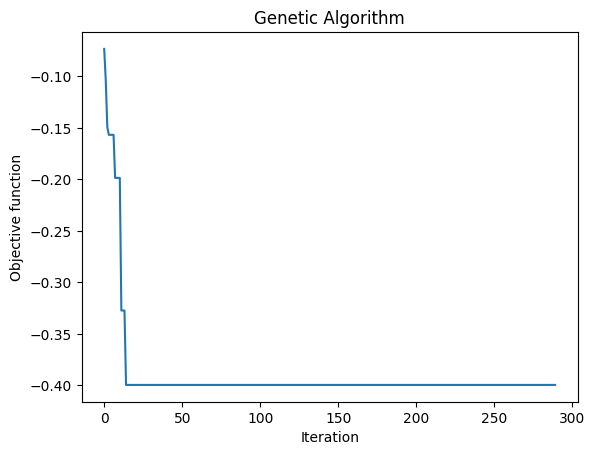

In [18]:
def f(X):
#     Objective function: Sharpe Ratio
    dim = len(X)         
    OF = 0
    pen = 0
    contrant = 0
    xicMa = 0
    for i in range(0, dim):
        contrant += X[i]
        OF += ((X[i])*expectedVector[i])
        for j in range(0, dim):
            xicMa += (X[i])*(X[j])*covMatrix[i ,j]        
#     Contrant of model by using penalty        
    if contrant >= K:
        pen = 500 + 1000*(contrant)        
    OF = OF/math.sqrt(xicMa)
    return - OF + pen

K = 10
numbersOfAssests = expectedVector.shape[0]
print(numbersOfAssests)
varbound=np.array([[0,1]]*numbersOfAssests)
algorithm_param =  {'max_num_iteration':100,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

# Use for TestData because it have a large number assets, set max_num_iteration to saving time run.
# model=ga(function=f,dimension=numbersOfAssests,variable_type='bool',variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Default for api data
model=ga(function=f,dimension=numbersOfAssests,variable_type='bool',variable_boundaries=varbound)

model.run()
outputDict = model.output_dict
while outputDict['function'] >= (500 + 1000*(K) - 1):
    model.run()
    outputDict = model.output_dict

Solve Model 2 (Quadratic programming)

In [ ]:
def chosenAssets(arr):
    chosenAssetsList = []
    for n in range(len(arr)):
        if arr[n] == 1:
            chosenAssetsList.append(n)
    return chosenAssetsList

chosenAssetsList = chosenAssets(outputDict['variable'])
numberOfAssets = len(chosenAssetsList)
P = np.zeros([numberOfAssets, numberOfAssets])
for i in range(numberOfAssets):
    for j in range(numberOfAssets):
        P[i, j] = covMatrix[chosenAssetsList[i] ,chosenAssetsList[j]]                              


expectedReturns = 0
q = np.array([0. for i in range(numberOfAssets)])
A = np.array([1. for i in range(numberOfAssets)])
b = np.array([1.])
G = np.array([-expectedVector[chosenAssetsList[i]] for i in range(numberOfAssets)])
h = np.array([-expectedReturns])
lb = 0 * np.ones(numberOfAssets)
ub = 1 * np.ones(numberOfAssets)
proportionOfAssetsList = solve_qp(P, q, G=G, h=h, A=A, b=b, lb=lb, ub=ub,solver="cvxopt")
print(f"Proportion Of Assets: x = {proportionOfAssetsList}")




Proportion Of Assets: x = [1.]


In [ ]:
def calSharpeRatio(assetsList, proportionOfAssetsList, expectedArr, covMatrix):
    xichMa = 0
    sharpeRatio = 0
    avarageReturn = 0
    dim = len(assetsList) 
    for i in range(0, dim):
        idxAsset1 = assetsList[i]
        avarageReturn += proportionOfAssetsList[i]*expectedArr[idxAsset1]
        for j in range(0, dim):
            idxAsset2 = assetsList[j]
            xichMa += (proportionOfAssetsList[i])*(proportionOfAssetsList[j])*covMatrix[idxAsset1 ,idxAsset2]
    sharpeRatio = avarageReturn/math.sqrt(xichMa)
    return sharpeRatio, avarageReturn, math.sqrt(xichMa)
 
    
testProportionOfAssetsList = [1 for i in range(len(chosenAssetsList))]    

valueOutTest = calSharpeRatio(chosenAssetsList, testProportionOfAssetsList, expectedVector, covMatrixOut)
print(f"Sharpe Ratio in sample Out by GA: {valueOutTest[0]}")
valueOut = calSharpeRatio(chosenAssetsList, proportionOfAssetsList, expectedVectorOut, covMatrixOut)
# print(valueOut)
print(f"Sharpe Ratio in sample Out: {valueOut[0]}")

print(f"Sharpe Ratio in sample In by GA: {-outputDict['function']}")
valueIn = calSharpeRatio(chosenAssetsList, proportionOfAssetsList, expectedVector, covMatrix)
print(f"Sharpe Ratio in sample In: {valueIn[0]}")

print(f"Choosen assets: ")
for idx in range(len(chosenAssetsList)):
    print(f"Asset:{chosenAssetsList[idx]} - {round(proportionOfAssetsList[idx]*100, 2)} %")

Sharpe Ratio in sample Out by GA: 0.6780603228186148
Sharpe Ratio in sample Out: 0.1517987233315578
Sharpe Ratio in sample In by GA: 1.8100073387723705
Sharpe Ratio in sample In: 1.8100073387723705
Choosen assets: 
Asset:0 - 100.0 %


In [ ]:
# Print name assets if it use api data
if len(covMatrix) == 16:
    nameOfAssets = ['BTC_USD', 'ETH_USD', 'XRP_USD', 'ADA_USD', 'TRX_USD', 'SOL_USD', 'UNI_USD', 'AVAX_USD', 'LINK_USD', 'BNB_USD', 'ATOM_USD', 'ETC_USD', 'NEAR_USD', 'FTM_USD', 'DOGE_USD', 'MATIC_USD']
    print(f"Chosen assets: ")
    for idx in range(len(chosenAssetsList)):
        print(f"{nameOfAssets[chosenAssetsList[idx]]} - {round(proportionOfAssetsList[idx]*100, 2)} %")
elif len(covMatrix) == 17: 
    nameOfAssets = ['BTC_USD', 'ETH_USD', 'XRP_USD', 'ADA_USD', 'TRX_USD', 'SOL_USD', 'UNI_USD', 'AVAX_USD', 'LINK_USD', 'BNB_USD', 'ATOM_USD', 'ETC_USD', 'NEAR_USD', 'LUNC_USD', 'FTM_USD', 'DOGE_USD', 'MATIC_USD']
    print(f"Chosen assets: ")
    for idx in range(len(chosenAssetsList)):
        print(f"{nameOfAssets[chosenAssetsList[idx]]} - {round(proportionOfAssetsList[idx]*100, 2)} %")

Chosen assets: 
BTC_USD - 100.0 %
